In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
from utils import format_node_names

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path = Path('./system_analytics_2024/slurm_data/system_states')
files = sorted(list(folder_path.glob("*.txt")))[0:-1]
files

[PosixPath('system_analytics_2024/slurm_data/system_states/system_states_1.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_2.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_3.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_4.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_5.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_6.txt')]

In [6]:

# for file_path in files:
def get_date_for_a_day(file_path):
    dict_list = []
    # file_path = folder_path / file
    with file_path.open(mode='r') as f:
        f_text = f.read()
    sinfo_day = f_text.split('############################')
    for sample_number in range(1, len(sinfo_day)-1):
        sinfo_sample = sinfo_day[sample_number].split('\n')
        time = sinfo_sample[1]
        for sample_row in range(4, len(sinfo_sample)-1):
            sample_row = np.random.randint(4, len(sinfo_sample)-1)
            node_number = int(sinfo_sample[sample_row].split()[7])
            state = sinfo_sample[sample_row].split()[8]
            node_names = sinfo_sample[sample_row].split()[-1]
            # print(format_node_names(node_names), node_number, state, time)
            d1 = {'node':format_node_names(node_names).split(','), 'time': [time] * node_number, 'state': [state]*node_number}
            dict_list.append(d1)
    df_list = [pd.DataFrame(d1) for d1 in dict_list]
    df = pd.concat(df_list, axis=0)
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values(['node', 'time'], inplace=True)
    return df
 
 


In [7]:
start_time = time.time()
with Pool(10) as pool:  # Initialize the pool with 4 processes
    parallel_results = pool.map(get_date_for_a_day, files)  # Submit tasks
parallel_duration = time.time() - start_time

In [8]:
df = pd.concat(parallel_results, axis=0)
df.sort_values(['node', 'time'], inplace=True)
display(df.head(), len(df))


,node,time,state
0,fcn1,2024-11-04 17:03:13,mixed
0,fcn1,2024-11-04 17:03:43,mixed
0,fcn1,2024-11-04 17:04:13,mixed
0,fcn1,2024-11-04 17:04:13,mixed
0,fcn1,2024-11-04 17:05:13,mixed


39469016

In [9]:

df_duplicated = df[df.duplicated(['node', 'time'])].copy()
df_duplicated = df_duplicated.sort_values(['node', 'time'])
display(len(df), len(df_duplicated), len(df) - len(df_duplicated))





39469016

19668573

19800443

'26784000'

In [13]:
N = 5000000
df_duplicated.iloc[N:N+10, :]


,node,time,state
90,tcn102,2024-11-10 00:32:32,allocated
90,tcn102,2024-11-10 00:33:32,allocated
90,tcn102,2024-11-10 00:33:32,allocated
90,tcn102,2024-11-10 00:33:32,allocated
90,tcn102,2024-11-10 00:34:02,allocated
90,tcn102,2024-11-10 00:34:02,allocated
90,tcn102,2024-11-10 00:34:02,allocated
90,tcn102,2024-11-10 00:34:32,allocated
90,tcn102,2024-11-10 00:34:32,allocated
91,tcn102,2024-11-10 00:36:02,allocated


In [28]:
len(df)

19520455

In [9]:

# why does duplication happen?
df.drop_duplicates(subset=['node', 'time', 'state'], inplace=True)

In [10]:
print(f"Numebr of duplicated rows based on node and time: {df.duplicated(['node', 'time']).sum()}")
display(df.describe(include='all'), df['state'].value_counts())





Numebr of duplicated rows based on node and time: 0


,node,time,state
count,19671182,19671182,19671182
unique,1548,NaN,20
top,gcn63,NaN,allocated
freq,16517,NaN,9947562
mean,NaN,2024-11-07 17:34:39.473268480,NaN
min,NaN,2024-11-04 17:03:13,NaN
25%,NaN,2024-11-06 05:29:51,NaN
50%,NaN,2024-11-07 17:28:23,NaN
75%,NaN,2024-11-09 05:41:33,NaN
max,NaN,2024-11-10 17:54:36,NaN


state
allocated      9947562
idle           6332287
mixed          2862103
reserved        382993
drained          76367
planned          31921
completing       19555
draining         10754
drained*          3449
down*             1324
unknown           1172
inval             1102
idle*              373
mixed*              97
allocated*          45
reboot^             30
down                17
draining*           16
completing*          9
mixed-               6
Name: count, dtype: int64

In [11]:
df.head()



,node,time,state
0,fcn1,2024-11-04 17:03:43,mixed
0,fcn1,2024-11-04 17:04:13,mixed
0,fcn1,2024-11-04 17:05:13,mixed
0,fcn1,2024-11-04 17:05:43,mixed
0,fcn1,2024-11-04 17:06:13,mixed


In [12]:
df.groupby('node')['node'].value_counts()

node
fcn1       14968
fcn10      14977
fcn100     10854
fcn101     10854
fcn102     10854
fcn103     10854
fcn104     10854
fcn105     10854
fcn106     10854
fcn107     10854
fcn108     10854
fcn109     10854
fcn11      15000
fcn110     10854
fcn111     10854
fcn112     10854
fcn113     10854
fcn114     10854
fcn115     10854
fcn116     10854
fcn117     10854
fcn118     10854
fcn119     10854
fcn12      14955
fcn120     10854
fcn13      14988
fcn14      14969
fcn15      15003
fcn16      14998
fcn17      14991
fcn18      15001
fcn19      15023
fcn2       14943
fcn20      15001
fcn21      14998
fcn22      14992
fcn23      14988
fcn24      14996
fcn25      15023
fcn26      14972
fcn27      14993
fcn28      14997
fcn29      14973
fcn3       14965
fcn30      14999
fcn31      14998
fcn32      15000
fcn33      14985
fcn34      14995
fcn35      14999
fcn36      15005
fcn37      14971
fcn38      15004
fcn39      15003
fcn4       14970
fcn40      14999
fcn41      14995
fcn42      15001
fcn43    

In [13]:
# add node_type and removing not workers node
df['node_type'] = df['node'].str[0:3]
df = df[df['node_type'].isin(['fcn', 'gcn', 'tcn', 'hcn'])].copy()
# put the time in an intervale
df['time_5min_rounded'] = (df['time'] - pd.Timedelta('2.5min')).dt.round(freq='5min')
df['time_30min_rounded'] = (df['time'] - pd.Timedelta('15min')).dt.round(freq='30min')
df['time_hour_rounde'] = (df['time'] - pd.Timedelta('30min')).dt.round(freq='h')
df['time_6hour_rounde'] = (df['time'] - pd.Timedelta('3h')).dt.round(freq='6h')
df['time_day_rounded'] = (df['time'] - pd.Timedelta('12h')).dt.round(freq='d')
# get a sample
df.sample(n=10)

,node,time,state,node_type,time_5min_rounded,time_30min_rounded,time_hour_rounde,time_6hour_rounde,time_day_rounded
194,tcn1021,2024-11-05 20:20:05,idle,tcn,2024-11-05 20:20:00,2024-11-05 20:00:00,2024-11-05 20:00:00,2024-11-05 18:00:00,2024-11-05
154,tcn960,2024-11-08 10:33:09,idle,tcn,2024-11-08 10:30:00,2024-11-08 10:30:00,2024-11-08 10:00:00,2024-11-08 06:00:00,2024-11-08
90,tcn1180,2024-11-08 17:48:41,mixed,tcn,2024-11-08 17:45:00,2024-11-08 17:30:00,2024-11-08 17:00:00,2024-11-08 12:00:00,2024-11-08
411,tcn1245,2024-11-05 09:30:37,idle,tcn,2024-11-05 09:30:00,2024-11-05 09:30:00,2024-11-05 09:00:00,2024-11-05 06:00:00,2024-11-05
31,gcn51,2024-11-08 22:54:05,mixed,gcn,2024-11-08 22:50:00,2024-11-08 22:30:00,2024-11-08 22:00:00,2024-11-08 18:00:00,2024-11-08
129,tcn1170,2024-11-06 08:09:13,mixed,tcn,2024-11-06 08:05:00,2024-11-06 08:00:00,2024-11-06 08:00:00,2024-11-06 06:00:00,2024-11-06
55,tcn626,2024-11-10 08:24:40,allocated,tcn,2024-11-10 08:20:00,2024-11-10 08:00:00,2024-11-10 08:00:00,2024-11-10 06:00:00,2024-11-10
104,tcn139,2024-11-06 22:24:37,allocated,tcn,2024-11-06 22:20:00,2024-11-06 22:00:00,2024-11-06 22:00:00,2024-11-06 18:00:00,2024-11-06
12,gcn86,2024-11-10 16:39:27,allocated,gcn,2024-11-10 16:35:00,2024-11-10 16:30:00,2024-11-10 16:00:00,2024-11-10 12:00:00,2024-11-10
1,tcn559,2024-11-08 23:25:47,reserved,tcn,2024-11-08 23:25:00,2024-11-08 23:00:00,2024-11-08 23:00:00,2024-11-08 18:00:00,2024-11-08


In [14]:
time_col = 'time_6hour_rounde'
df_temp = df.groupby(['node',time_col], as_index=False)['state'].value_counts(normalize=True)
df_temp.sort_values(['node', time_col], inplace=True)
df_temp.sample(n=10)

,node,time_6hour_rounde,state,proportion
32157,tcn377,2024-11-04 12:00:00,allocated,0.0714
43189,tcn627,2024-11-06 00:00:00,allocated,1.0000
22146,tcn151,2024-11-06 12:00:00,allocated,1.0000
4434,gcn108,2024-11-06 18:00:00,idle*,0.0067
55119,tcn909,2024-11-04 18:00:00,idle,0.1442
45005,tcn667,2024-11-05 12:00:00,idle,0.5714
40452,tcn569,2024-11-05 18:00:00,allocated,1.0000
57858,tcn984,2024-11-09 06:00:00,idle,1.0000
34686,tcn431,2024-11-09 00:00:00,allocated,1.0000
44203,tcn65,2024-11-08 18:00:00,allocated,1.0000


In [15]:
# get the idle state only
df_idle = df_temp[(df_temp['state']=='idle')].copy()
df_idle.drop(columns='state', inplace=True)
df_idle.rename(columns={'proportion':'idle'}, inplace=True)
# get the not idle states and add their share
df_not_idle = df_temp[(df_temp['state']!='idle')].copy()
df_not_idle = df_not_idle.groupby(['node', time_col], as_index=False)['proportion'].sum().copy()
df_not_idle.rename(columns={'proportion':'not_idle'}, inplace=True)
# join the two data frame based on node and time
df_stat = pd.merge(df_idle, df_not_idle, how='outer', on=['node', time_col])
df_stat.fillna(value=0, inplace=True)
df_stat.sort_values(['node', time_col], inplace=True)
display(df_idle.tail(), df_not_idle.tail(), df_stat.tail())

,node,time_6hour_rounde,idle
58287,tcn999,2024-11-09 12:00:00,1.0
58288,tcn999,2024-11-09 18:00:00,1.0
58289,tcn999,2024-11-10 00:00:00,1.0
58290,tcn999,2024-11-10 06:00:00,1.0
58291,tcn999,2024-11-10 12:00:00,1.0


,node,time_6hour_rounde,not_idle
27390,tcn995,2024-11-07 12:00:00,0.0022
27391,tcn996,2024-11-07 12:00:00,0.0022
27392,tcn997,2024-11-07 12:00:00,0.0022
27393,tcn998,2024-11-07 12:00:00,0.0022
27394,tcn999,2024-11-07 12:00:00,0.0022


,node,time_6hour_rounde,idle,not_idle
38445,tcn999,2024-11-09 12:00:00,1.0,0.0
38446,tcn999,2024-11-09 18:00:00,1.0,0.0
38447,tcn999,2024-11-10 00:00:00,1.0,0.0
38448,tcn999,2024-11-10 06:00:00,1.0,0.0
38449,tcn999,2024-11-10 12:00:00,1.0,0.0


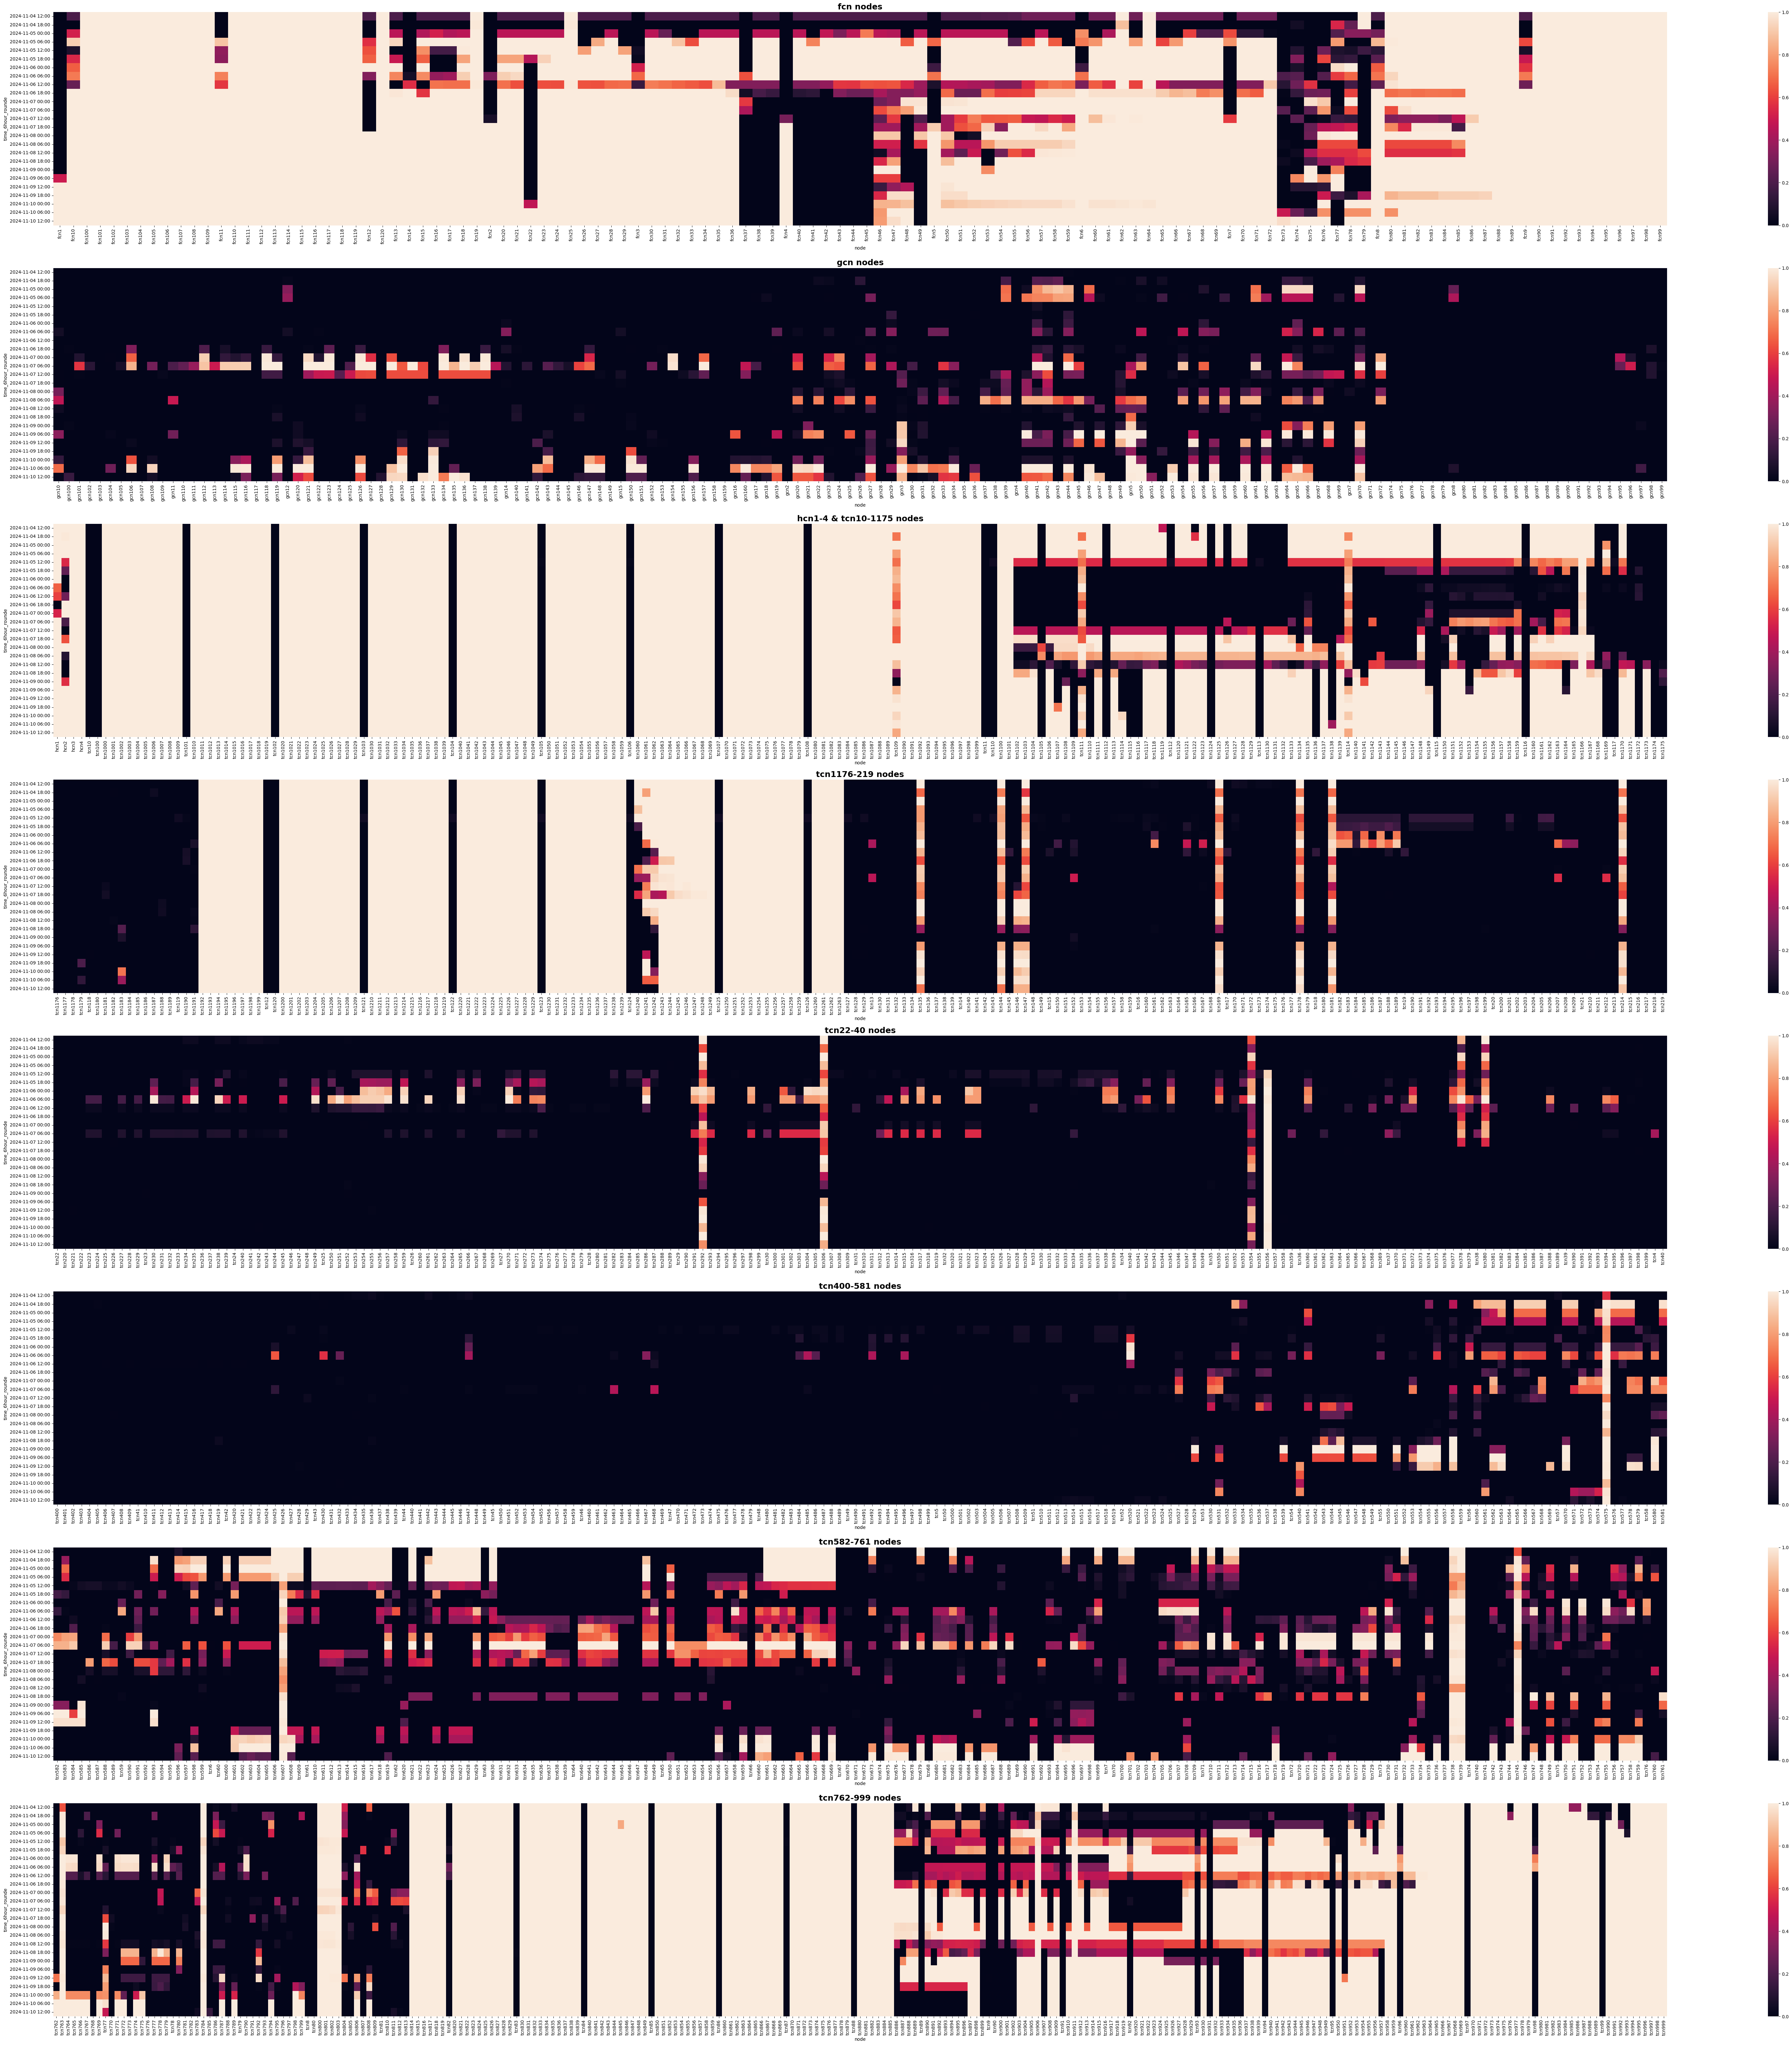

In [16]:
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 80))


# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]
titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_stat_pivot.iloc[:, start:end], ax=ax[i], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot

# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Ensures everything fits within figure dimensions
plt.show()

In [17]:
ascending_node_names = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_sorted_nodes = df_stat_pivot[ascending_node_names].copy()

df_sorted_nodes.head()

node               tcn99  tcn29  tcn97  tcn782  tcn288  tcn299  tcn740  \
time_6hour_rounde                                                        
2024-11-04 12:00     0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00     0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00     0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00     0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00     0.0    0.0    0.0     0.0     0.0     0.0     0.0   

node               tcn741  tcn737  tcn28  tcn73  tcn277  gcn103  tcn276  \
time_6hour_rounde                                                         
2024-11-04 12:00      0.0     0.0    0.0    0.0     0.0     0.0     0.0   
2024-11-04 18:00      0.0     0.0    0.0    0.0     0.0     0.0     0.0   
2024-11-05 00:00      0.0     0.0    0.0    0.0     0.0     0.0     0.0   
2024-11-05 06:00      0.0     0.0    0.0    0.0     0.0     0.0     0.0   
2024-11-05 12:00      0.0     0.0    0.0    0.0     0.0     0.0     0.0   

node               tcn81  tcn690  tcn179  tcn156  tcn396  tcn402  tcn89  \
time_6hour_rounde                                                         
2024-11-04 12:00     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-04 18:00     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-05 00:00     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-05 06:00     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-05 12:00     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

node               tcn931  tcn154  tcn153  tcn155  tcn535  tcn472  tcn471  \
time_6hour_rounde                                                           
2024-11-04 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node               tcn466  gcn158  gcn149  tcn647  tcn103  tcn510  tcn523  \
time_6hour_rounde                                                           
2024-11-04 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node               tcn528  tcn53  tcn408  tcn410  tcn104  tcn478  tcn479  \
time_6hour_rounde                                                          
2024-11-04 12:00      0.0    0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00      0.0    0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00      0.0    0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00      0.0    0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00      0.0    0.0     0.0     0.0     0.0     0.0     0.0   

node               tcn48  tcn480  tcn482  tcn488  tcn490  tcn491  tcn423  \
time_6hour_rounde                                                          
2024-11-04 12:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node               tcn424  tcn426  tcn431  gcn159  gcn2  tcn324  tcn475  \
time_6hour_rounde                                                         
2024-11-04 12:00      0.0     0.0     0.0     0.0   0.0     0.0     0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0   0.0   

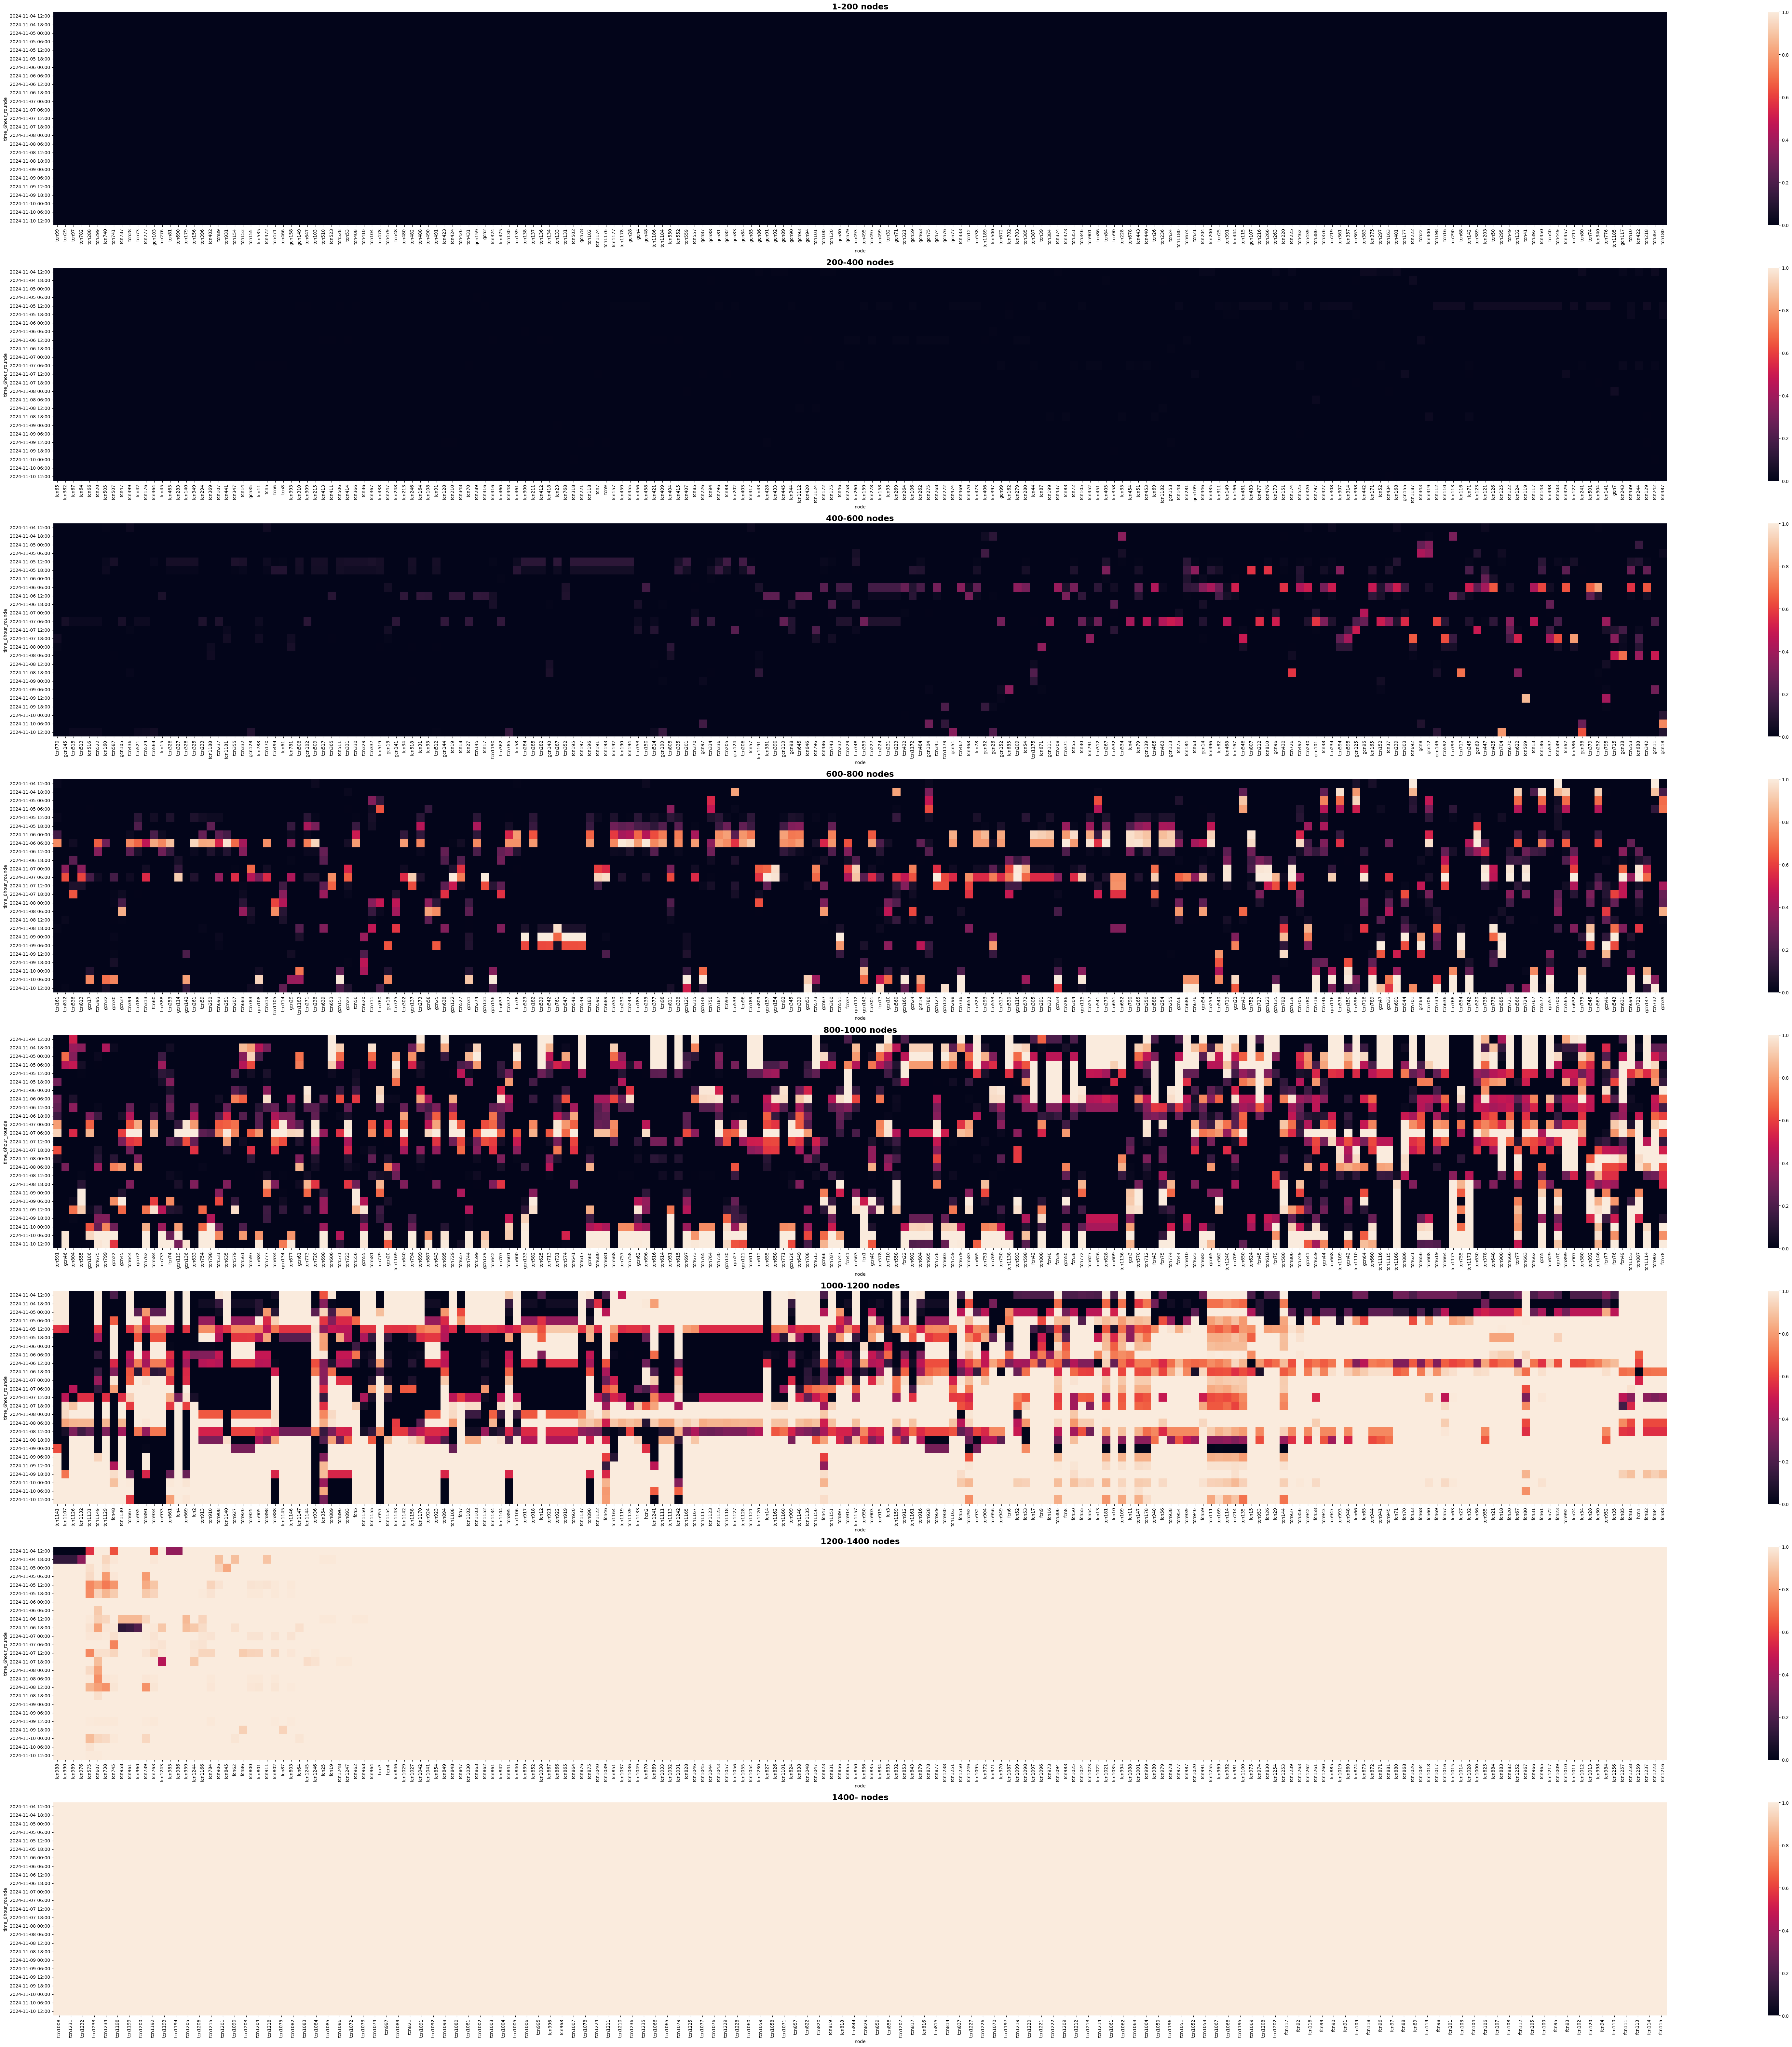

In [18]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 80))
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_sorted_nodes.iloc[:, start:end], vmin=0, vmax=1,xticklabels=True, yticklabels=True,
                ax=ax[i], cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot
    # Set x and y tick parameters to bold font
    # ax[i].tick_params(axis='x', labelsize=12)  # Bold x-tick labels
    # ax[i].tick_params(axis='y', labelsize=12)   # Bold y-tick labels

# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Ensures everything fits within figure dimensions
plt.show()